<a href="https://colab.research.google.com/github/purvasingh96/pytorch-examples/blob/master/Images/02_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning
In this notebook, I have shown how to train a convolutional neural network for image classification using transfer learning. <br>

Two major transfer learning scenarios look as follows:

1. **Finetuning the convnet:** Instead of random initializaion, we initialize the network with a pretrained network, like the one that is trained on imagenet 1000 dataset. Rest of the training looks as usual.
2. **ConvNet as fixed feature extractor**: Here, we will freeze the weights for all of the network except that of the final fully connected layer. This last fully connected layer is replaced with a new one with random weights and only this layer is trained.

# Import Libraries

In [0]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

# Data Transformation

In [0]:
data_transforms = {
    'train': transforms.Compose([
                                 transforms.RandomResizedCrop(224),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
                                transforms.Resize(256), 
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])


    ])
}


In [7]:
!unzip hymenoptera_data.zip

Archive:  hymenoptera_data.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of hymenoptera_data.zip or
        hymenoptera_data.zip.zip, and cannot find hymenoptera_data.zip.ZIP, period.


## Create DataLoaders for training and validation data

In [10]:
!unzip hymenoptera_data.zip
data_dir = 'hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                    for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=2)
                    for x in ['train', 'val']}
trainloader = torch.utils.data.DataLoader(image_datasets['train'], batch_size=4, shuffle=True, num_workers=2)
validloader = torch.utils.data.DataLoader(image_datasets['val'], batch_size=4, shuffle=True, num_workers=2)
dataset_sizes = {x: len(image_datasets[x])
                    for x in ['train', 'val']}
class_names = image_datasets['train'].classes
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(class_names)


Archive:  hymenoptera_data.zip
   creating: hymenoptera_data/
   creating: hymenoptera_data/train/
   creating: hymenoptera_data/train/ants/
  inflating: hymenoptera_data/train/ants/0013035.jpg  
  inflating: hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg  
  inflating: hymenoptera_data/train/ants/1095476100_3906d8afde.jpg  
  inflating: hymenoptera_data/train/ants/1099452230_d1949d3250.jpg  
  inflating: hymenoptera_data/train/ants/116570827_e9c126745d.jpg  
  inflating: hymenoptera_data/train/ants/1225872729_6f0856588f.jpg  
  inflating: hymenoptera_data/train/ants/1262877379_64fcada201.jpg  
  inflating: hymenoptera_data/train/ants/1269756697_0bce92cdab.jpg  
  inflating: hymenoptera_data/train/ants/1286984635_5119e80de1.jpg  
  inflating: hymenoptera_data/train/ants/132478121_2a430adea2.jpg  
  inflating: hymenoptera_data/train/ants/1360291657_dc248c5eea.jpg  
  inflating: hymenoptera_data/train/ants/1368913450_e146e2fb6d.jpg  
  inflating: hymenoptera_data/train/ants/147318

# Train your model

You can also have a look at [Training and Validating model](https://github.com/purvasingh96/Deep-learning-with-neural-networks/blob/master/Deep-learning-with-pytorch/2.%20Convolution%20Neural%20Networks/CFIAR_image_classifier.ipynb)

In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
  best_model = copy.deepcopy(model.state_dict())
  best_acc=0.0

  for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs-1))
    print('-'*10)

    for phase in ['train', 'val']:
      if phase=='train':
        model.train()
      else:
        model.eval()
      running_loss=0.0
      running_correct=0.0
      for inputs, labels in dataloaders[phase]:
        inputs=inputs.to(device)
        labels=labels.to(device)

        optimizer.zero_grad()
        with torch.set_grad_enabled(phase == 'train'):
          outputs = model(inputs)
          _, preds = torch.max(outputs, 1)
          loss = criterion(outputs, labels)

          if phase=='train':
            loss.backward()
            optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        running_correct += torch.sum(preds==labels.data)
      if phase=='train':
        scheduler.step()
      
      epoch_loss = running_loss / dataset_sizes[phase]
      epoch_acc = running_correct.double() / dataset_sizes[phase]

      print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

      if phase == 'val' and epoch_acc>best_acc:
        best_acc = epoch_acc
        best_model = copy.deepcopy(model.state_dict())
  
  model.load_state_dict(best_model)
  return model



## Boiler code to view images

In [0]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## Finetuning the convnet

In [0]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
  param.requires_grad = False

num_features = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_features, 2)

model_conv = model_conv.to(device)
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model_conv.parameters(), lr=0.001, momentum = 0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


## Training and Evaluation

In [26]:
model_conv = train_model(model_conv, criterion, optimizer, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.7956 Acc: 0.5656
val Loss: 0.2162 Acc: 0.9216
Epoch 1/24
----------
train Loss: 0.7272 Acc: 0.7090
val Loss: 0.2419 Acc: 0.9216
Epoch 2/24
----------
train Loss: 0.4943 Acc: 0.7787
val Loss: 0.1955 Acc: 0.9150
Epoch 3/24
----------
train Loss: 0.3802 Acc: 0.8566
val Loss: 0.1835 Acc: 0.9346
Epoch 4/24
----------
train Loss: 0.5232 Acc: 0.7869
val Loss: 0.2163 Acc: 0.9085
Epoch 5/24
----------
train Loss: 0.6917 Acc: 0.7008
val Loss: 0.2169 Acc: 0.9216
Epoch 6/24
----------
train Loss: 0.4215 Acc: 0.8115
val Loss: 0.2559 Acc: 0.8954
Epoch 7/24
----------
train Loss: 0.3369 Acc: 0.8566
val Loss: 0.1775 Acc: 0.9346
Epoch 8/24
----------
train Loss: 0.4956 Acc: 0.7910
val Loss: 0.2214 Acc: 0.9150
Epoch 9/24
----------
train Loss: 0.3599 Acc: 0.8607
val Loss: 0.1959 Acc: 0.9216
Epoch 10/24
----------
train Loss: 0.3732 Acc: 0.8484
val Loss: 0.2353 Acc: 0.9085
Epoch 11/24
----------
train Loss: 0.3361 Acc: 0.8525
val Loss: 0.2165 Acc: 0.9216
Epoch 12/24
--

## View the results

In [0]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


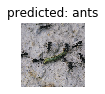

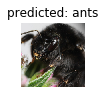

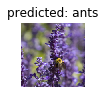

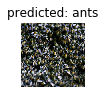

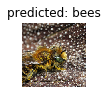

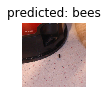

In [24]:
visualize_model(model_conv)

## ConvNet as a fixed feature extractor
We need to freeze all the network except the final layer. We need to set requires_grad == False to freeze the parameters so that the gradients are not computed in backward().
<br><br>
On CPU this will take about half the time compared to previous scenario. This is expected as gradients don’t need to be computed for most of the network. However, forward does need to be computed.

In [0]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
  param.requires_grad = False

num_fetaures = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_features, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()


# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)



In [30]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.7131 Acc: 0.6475
val Loss: 0.2415 Acc: 0.9216
Epoch 1/24
----------
train Loss: 0.5920 Acc: 0.7377
val Loss: 0.1641 Acc: 0.9608
Epoch 2/24
----------
train Loss: 0.4433 Acc: 0.7705
val Loss: 0.2478 Acc: 0.9150
Epoch 3/24
----------
train Loss: 0.7248 Acc: 0.7172
val Loss: 0.2500 Acc: 0.9281
Epoch 4/24
----------
train Loss: 0.4308 Acc: 0.8361
val Loss: 0.1619 Acc: 0.9412
Epoch 5/24
----------
train Loss: 0.5141 Acc: 0.7869
val Loss: 0.1798 Acc: 0.9477
Epoch 6/24
----------
train Loss: 0.4870 Acc: 0.8033
val Loss: 0.2586 Acc: 0.9150
Epoch 7/24
----------
train Loss: 0.5027 Acc: 0.7869
val Loss: 0.1669 Acc: 0.9346
Epoch 8/24
----------
train Loss: 0.3640 Acc: 0.8525
val Loss: 0.1699 Acc: 0.9412
Epoch 9/24
----------
train Loss: 0.3453 Acc: 0.8320
val Loss: 0.1560 Acc: 0.9608
Epoch 10/24
----------
train Loss: 0.4404 Acc: 0.8156
val Loss: 0.1666 Acc: 0.9739
Epoch 11/24
----------
train Loss: 0.3868 Acc: 0.8484
val Loss: 0.1499 Acc: 0.9477
Epoch 12/24
--

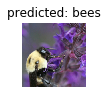

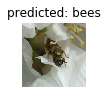

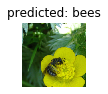

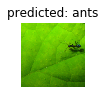

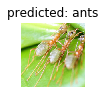

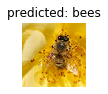

In [31]:
visualize_model(model_conv)

plt.ioff()
plt.show()